# 1. 데이터 및 라이브러리 불러오기

### [라이브러리 불러오기]

In [1]:
!pip install optuna

In [2]:
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

import re, tqdm
import pandas as pd
import numpy as np
import datetime
from scipy import stats
from scipy.stats import shapiro

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 모델링
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# 파라미터 튜닝
import optuna
from optuna import Trial
from sklearn.model_selection import GridSearchCV

# 모델 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

- 한글 폰트 설정

In [3]:
# 한글 폰트 사용을 위한 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


NanumGothic = C:\Windows\Fonts\.TTF
NanumGothic = C:\Windows\Fonts\BOLD.TTF
NanumGothic = C:\Windows\Fonts\EXTRABOLD.TTF


'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


- 경로 설정

In [4]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@d9a9a1289fe0-ad8114ded8c744e3993705c84e0e0b9e: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@d9a9a1289fe0-ad8114ded8c744e3993705c84e0e0b9e: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@d9a9a1289fe0-ad8114ded8c744e3993705c84e0e0b9e: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@d9a9a1289fe0-ad8114ded8c744e3993705c84e0e0b9e: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 200
root@d9a9a1289fe0-ad8114ded8c744e3993705c84e0e0b9e: cat /tmp/tmpl23xozfh/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [5]:
import os
os.chdir('./drive/MyDrive/Colab Notebooks/[부산대학교] 구내 식당 식시 인원 예측 AI 경진대회')

### [데이터 불러오기]

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [6]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [7]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


# 2. 데이터 EDA 및 전처리

### [데이터 확인]

- 데이터 구조

In [8]:
print("train shape :", train.shape)
print("test shape :", test.shape)
print("submission shape :", submission.shape)

train shape : (1205, 12)
test shape : (50, 10)
submission shape : (50, 3)


- 데이터 정보

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [11]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      50 non-null     object
 1   중식계     50 non-null     int64 
 2   석식계     50 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


- 결측치 확인

In [12]:
train.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
dtype: int64

In [13]:
test.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
dtype: int64

> 결측치 없음.

### [산점도 분석]

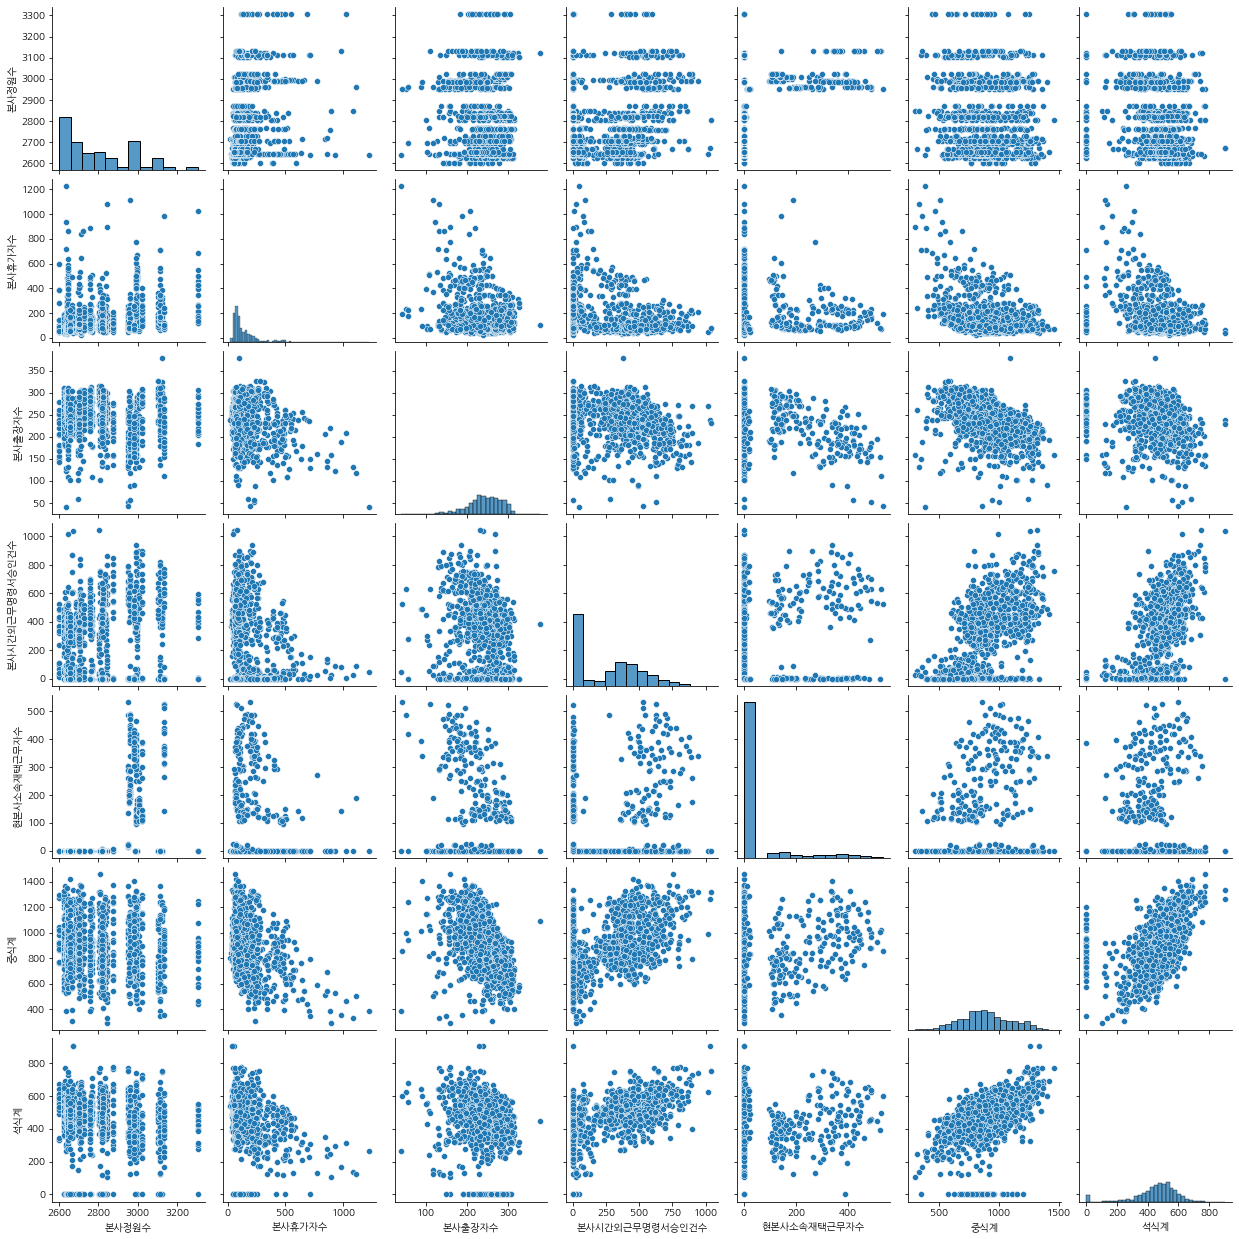

In [14]:
sns.pairplot(train)

> 중식 <-> 석식 / 중식 <-> 본사시간외근무명령서승인건수 / 석식 <-> 본사시간외근무명령서승인건수 사이에   
약간의 선형관계가 있는 것으로 보여짐.

### [상관분석]

<AxesSubplot:title={'center':'Correlation of Features'}>

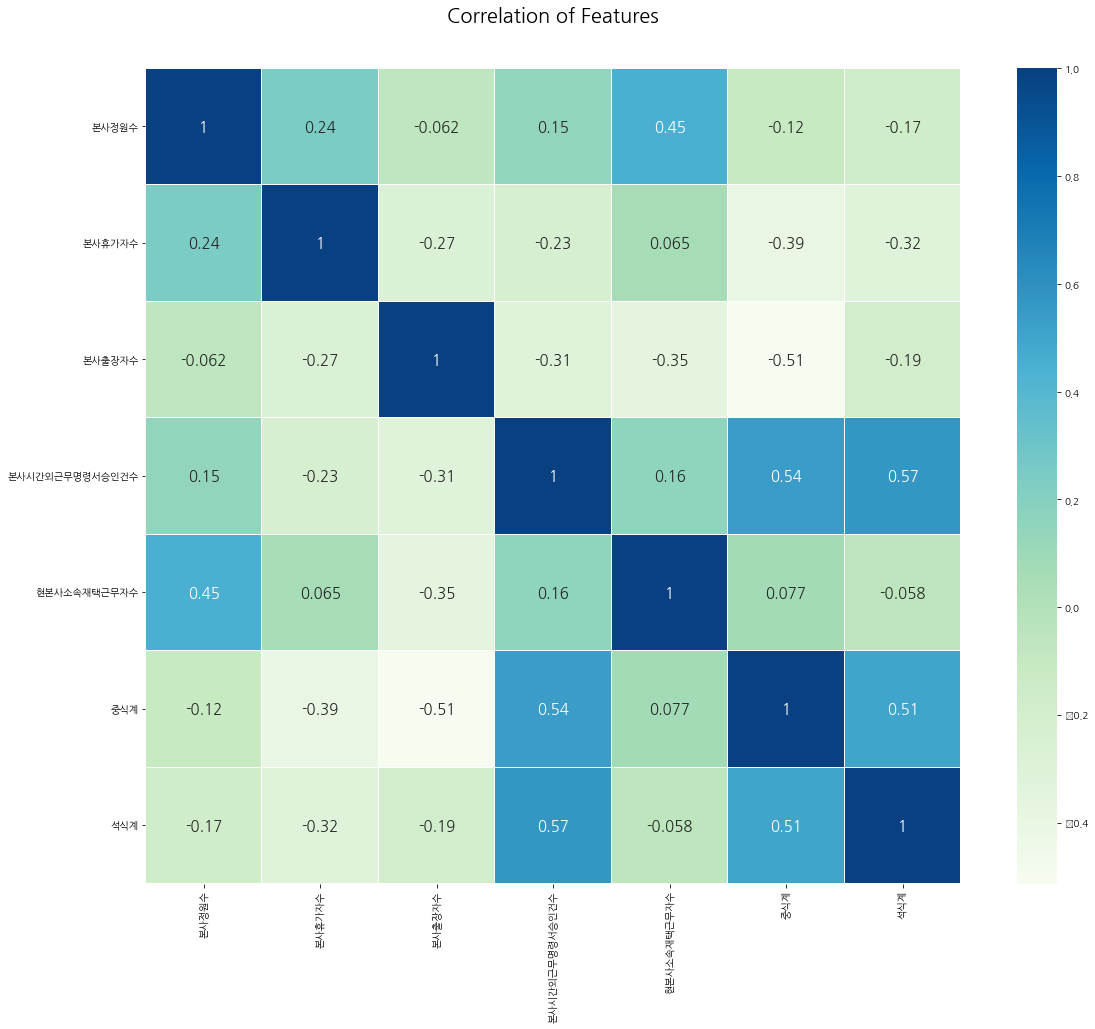

In [15]:
# heatmap
colormap = plt.cm.GnBu 
plt.figure(figsize=(20, 15)) 
plt.title("Correlation of Features", y = 1.05, size = 20) 
sns.heatmap(train.corr(), 
            linewidths = 0.1, 
            vmax = 1.0, 
            square = True, 
            cmap = colormap, 
            linecolor = "white", 
            annot = True, 
            annot_kws = {"size" : 15})

> **<중식계와 석식계 사이에 비교적 강한 양의 상관관계가 있다.>**  
> => 점심을 먹은 사람은 저녁도 먹을 가능성이 큼  
> => 위사람들은 보통 시간을 절약하기 위해 점심과 저녁을 구내 식당에서 해결한다고 판단  
> => 하지만 메뉴가 마음에 안든다면 밖에서 사먹는 것으로 예상  

> **<중식계와 석식계는 각각 본사시간외근무명령서승인건수와 비교적 강한 양의 상관관계가 있다.>**  
> => 초과 근무를 하는 경우, 점심과 저녁을 구내 식당에서 해결한다고 판단  
> => 초과 근무를 하는 경우, 할 일이 많기 때문에 시간을 절약할 필요가 있음

### [요일별 식수인원]

- 중식계

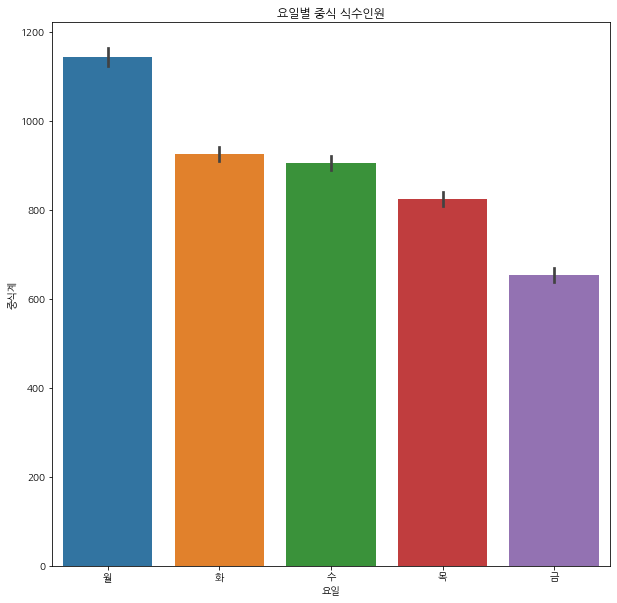

In [16]:
plt.figure(figsize=(10,10))


sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 중식 식수인원")
plt.show()

> 월요일이 가장 많고, 월 -> 화 -> 수 -> 목 -> 금 순임. 

- 석식계

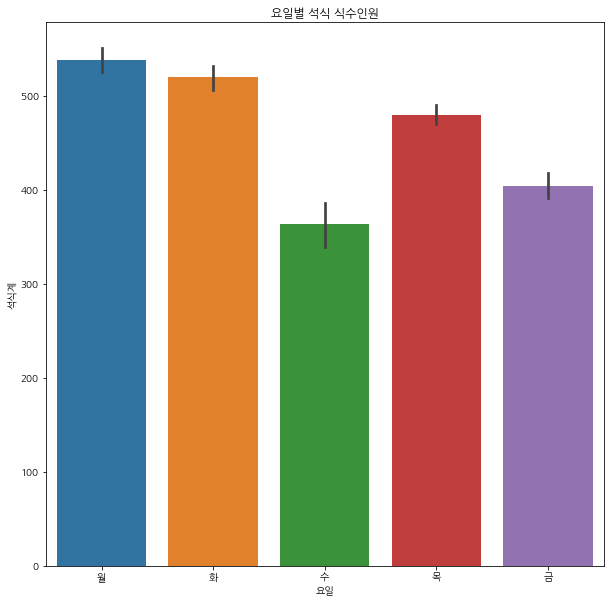

In [17]:
plt.figure(figsize=(10,10))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 석식 식수인원")
plt.show()

> 석식계 또한 월요일이 가장 많으나, 중식계만큼 화요일과 큰 차이는 없음.  
> 월 -> 화 -> 목 -> 금 -> 수 순임.  
> 수요일 식수인원이 크게 감소  => 수요일 메뉴가 별로인가?

----------------------------------------------------------
> 대체적으로 석식 식수인원보다 중식 식수인원이 더 많음.  
> 저녁은 보통 퇴근하고 집에가서 먹는다고 판단  

### [정규성 검사]

- 중식계

Mat_A Shapiro-Wilk Test: statistic=0.9926197528839111, p-value=1.0172469956160057e-05



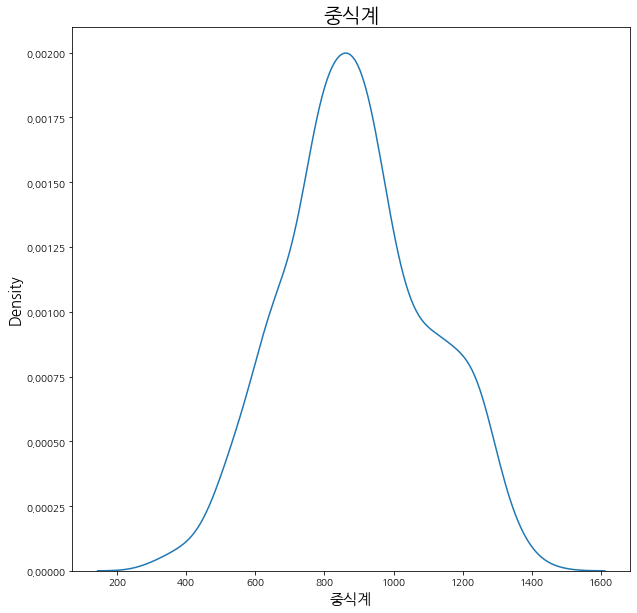

In [18]:
# shapiro 정규성 검사
statistic, p=shapiro(train["중식계"])
print("Mat_A Shapiro-Wilk Test: statistic={}, p-value={}\n".format(statistic, p))

# 시각화
plt.figure(figsize=(10,10))
x = train['중식계']
sns.kdeplot(x)
plt.title("중식계", fontsize=20)
plt.xlabel("중식계", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.show()

> 그래프를 보았을 때, 정규성을 가진다고 생각할 수 있지만,  
> p-value < 0.05이므로 귀무가설 기각 => 정규성을 가지지 않는다고 판단  

- 석식계

Mat_A Shapiro-Wilk Test: statistic=0.9092884063720703, p-value=3.4599128072714565e-26



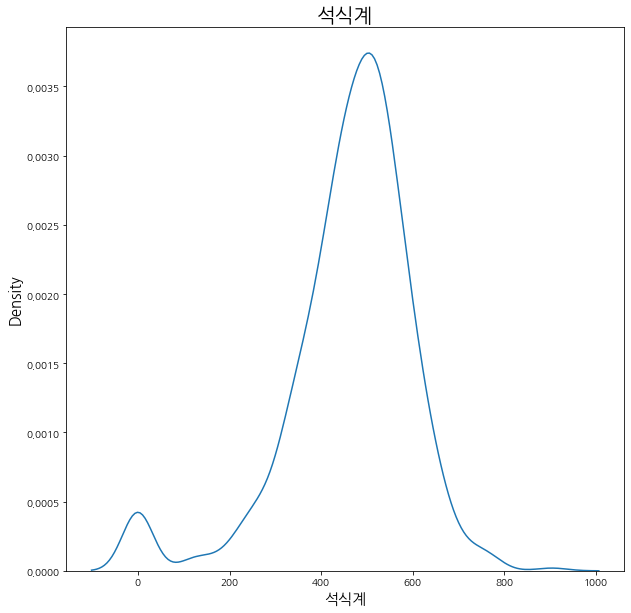

In [19]:
# shapiro 정규성 검사
statistic, p=shapiro(train["석식계"])
print("Mat_A Shapiro-Wilk Test: statistic={}, p-value={}\n".format(statistic, p))

# 시각화
plt.figure(figsize=(10,10))
x = train['석식계']
sns.kdeplot(x)
plt.title("석식계", fontsize=20)
plt.xlabel("석식계", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.show()

> 그래프를 보았을 때, 정규성을 가진다고 생각할 수 있지만,  
> p-value < 0.05이므로 귀무가설 기각 => 정규성을 가지지 않는다고 판단

### [현재 본사에 있는 인원] - 파생변수 생성

In [20]:
# flaot형인 인원 수를 int형으로 변경
train["현본사소속재택근무자수"] = train["현본사소속재택근무자수"].astype("int")
train["중식계"] = train["중식계"].astype("int")
train["석식계"] = train["석식계"].astype("int")

- 현재 잔류 인원 계산

In [21]:
train['present'] = train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수']
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,present
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2401


- 총 본사정원수 대비 현재 잔류 인원, 중식계, 석식계 식수인원

In [22]:
print(train['본사정원수'].max()) #총인원 3305
print('\n')
print(train['present'].max()) #총인원 2921
print('\n')
print(train['중식계'].describe()) #최대 1459
print('\n')
print(train['석식계'].describe()) #최대 905

3305


2921


count    1205.000000
mean      890.334440
std       209.505057
min       296.000000
25%       758.000000
50%       879.000000
75%      1032.000000
max      1459.000000
Name: 중식계, dtype: float64


count    1205.000000
mean      461.772614
std       139.179202
min         0.000000
25%       406.000000
50%       483.000000
75%       545.000000
max       905.000000
Name: 석식계, dtype: float64


> 현재 잔류 인원 대비, 중식계와 석식계 둘다 절반도 못 미침.  
> 정원수와 식수인원은 큰 관계가 없어 보임.  

- test 데이터 파생변수 생성

In [23]:
# flaot형인 인원 수를 int형으로 변경
test["현본사소속재택근무자수"] = test["현본사소속재택근무자수"].astype("int")

# 현재 잔류 인원 계산
test['present'] = test['본사정원수'] - test['본사휴가자수'] - test['본사출장자수'] - test['현본사소속재택근무자수']
test.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,present
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2355


### [날짜 정리] - 파생 변수 생성

In [24]:
train['일자'] = pd.to_datetime(train['일자'])  # 데이터 타입 시계열 데이터로 변경
train['year'] = train['일자'].dt.strftime('%Y')  # 년도
train['month'] = train['일자'].dt.strftime('%m')  # 월
train['yearmonth'] = train['일자'].dt.strftime('%y%m')  # 연월 / 일 수는 큰 영향력이 없을 거라 판단.
train['day'] = train["일자"].dt.strftime("%d") # 일

train.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,present,year,month,yearmonth,day
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2401,2016,02,1602,01
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2378,2016,02,1602,02


### [날짜별 식수인원]

- 연도별 중식 식수인원

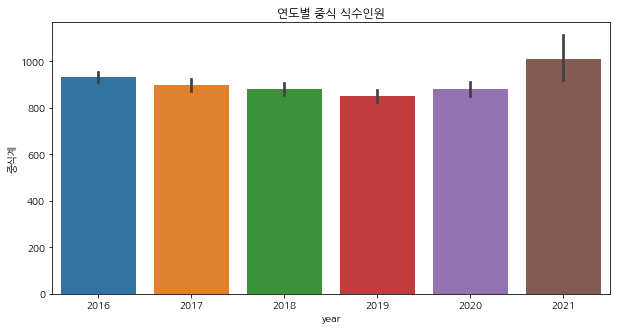

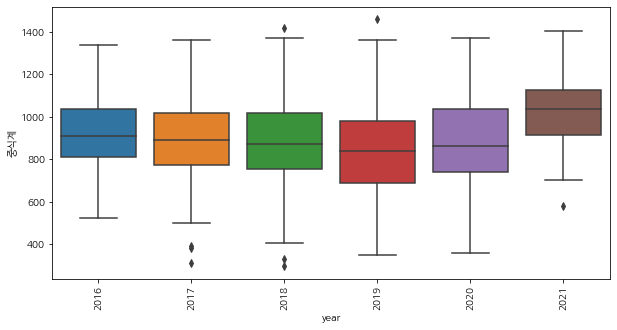

In [25]:
# barplot
plt.figure(figsize=(10,5))


sns.barplot(x="year", y="중식계", data=train)
plt.title("연도별 중식 식수인원")
plt.show()

# boxplot
plt.figure(figsize=(10,5))
rot = sns.boxplot(x='year',y='중식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

> 코로나 이후, 식수인원이 줄어들 것으로 예상했으나 오히려 오름

- 연도별 석식 식수인원

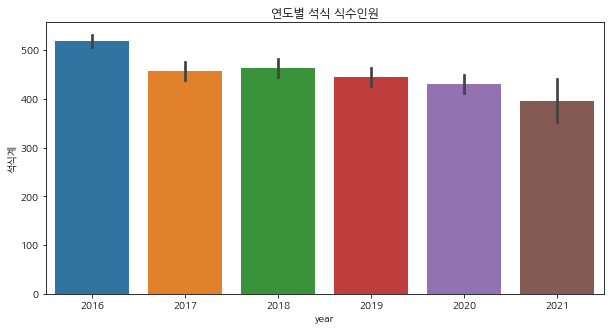

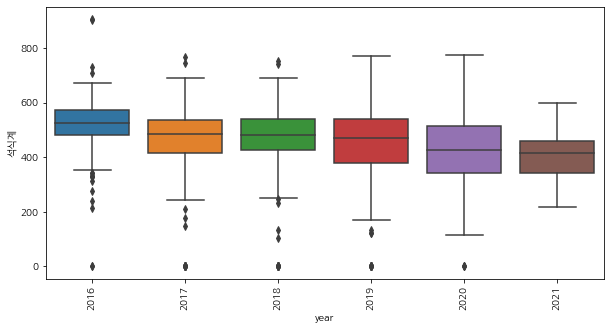

In [26]:
# barplot
plt.figure(figsize=(10,5))


sns.barplot(x="year", y="석식계", data=train)
plt.title("연도별 석식 식수인원")
plt.show()

# boxplot
plt.figure(figsize=(10,5))
rot = sns.boxplot(x='year',y='석식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

> 코로나 이후, 중식 식수인원을 증가했으나 석식 식수인원은 감소  
------------------------------------------------------------------------------  
> 코로나 이후, 밖에 나가서 식사하는 것보다 안에서 빠르게 먹는 것을 선호한다고 판단  
> 단, 점심은 어쩔 수 없으나 저녁은 보통 집에 가서 먹는 것으로 판단

- 월별 중식 식수인원

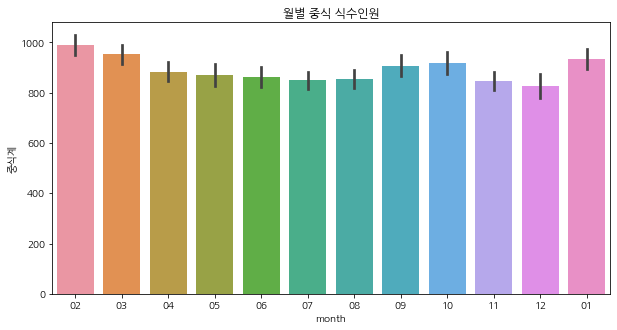

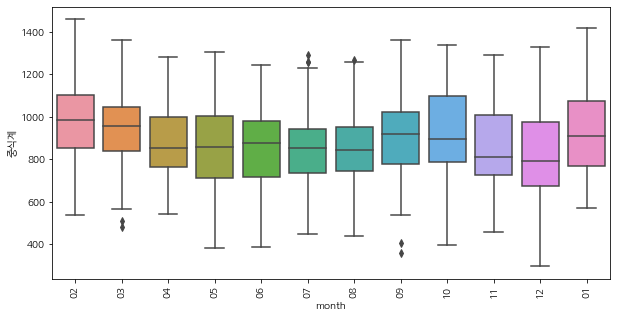

In [27]:
# barplot
plt.figure(figsize=(10,5))


sns.barplot(x="month", y="중식계", data=train)
plt.title("월별 중식 식수인원")
plt.show()

# boxplot
plt.figure(figsize=(10,5))
rot = sns.boxplot(x='month',y='중식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

- 월별 석식 식수인원

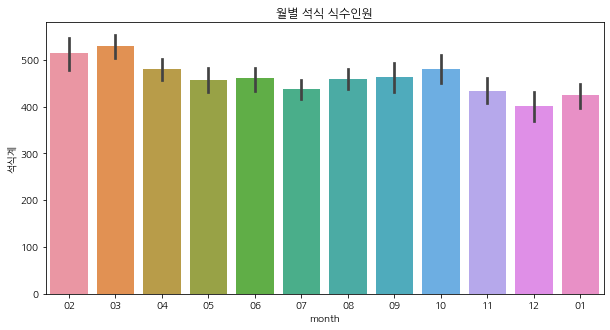

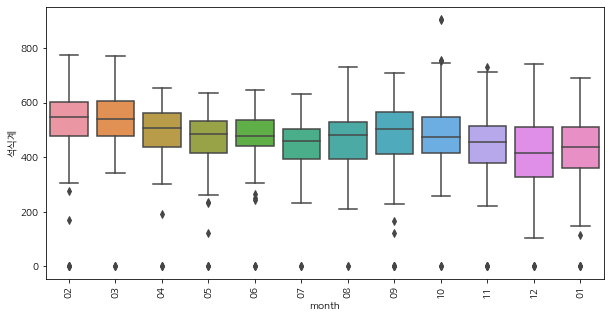

In [28]:
# barplot
plt.figure(figsize=(10,5))


sns.barplot(x="month", y="석식계", data=train)
plt.title("월별 석식 식수인원")
plt.show()

# boxplot
plt.figure(figsize=(10,5))
rot = sns.boxplot(x='month',y='석식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

> 중식과 석식 모두 12월에 식수 인원이 감소  
> => 연말이라 회식이 많을 것으로 예상

- 월일별 중식 식수인원

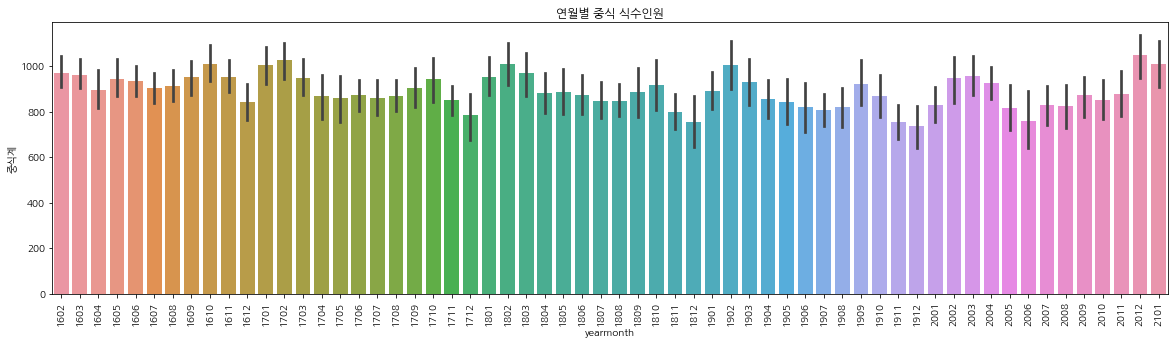

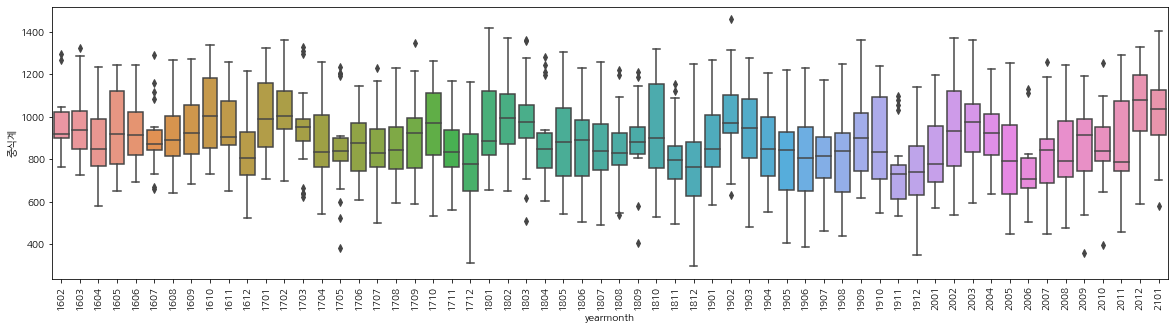

In [29]:
# barplot
plt.figure(figsize=(20,5))


sns.barplot(x="yearmonth", y="중식계", data=train)
plt.title("연월별 중식 식수인원")
plt.xticks(rotation =90)
plt.show()

# boxplot
plt.figure(figsize=(20,5))
rot = sns.boxplot(x='yearmonth',y='중식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

- 연월별 석식 식수인원

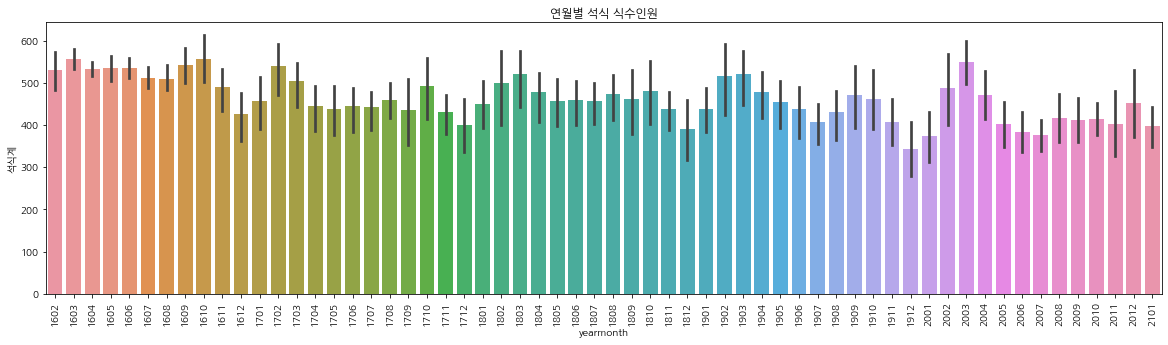

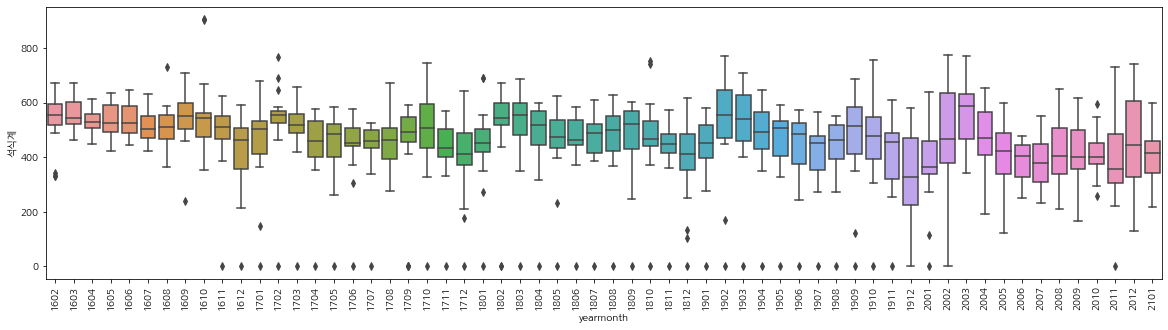

In [30]:
# barplot
plt.figure(figsize=(20,5))


sns.barplot(x="yearmonth", y="석식계", data=train)
plt.title("연월별 석식 식수인원")
plt.xticks(rotation =90)
plt.show()

# boxplot
plt.figure(figsize=(20,5))
rot = sns.boxplot(x='yearmonth',y='석식계', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

> 대체적으로 연도별 비슷한 추세를 보이나, 해가 갈수록 데이터 분포의 차이가 커지는 것으로 판단  

In [31]:
# 연월은 식수인원에 큰 영향이 없다고 판단
train.drop('yearmonth', inplace=True , axis=1)

- test 데이터 파생변수 생성

In [32]:
test['일자'] = pd.to_datetime(test['일자'])  # 데이터 타입 시계열 데이터로 변경
test['year'] = test['일자'].dt.strftime('%Y')  # 년도
test['month'] = test['일자'].dt.strftime('%m')  # 월
test['day'] = test["일자"].dt.strftime("%d") # 일

test.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,present,year,month,day
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2355,2021,01,27
1,2021-01-28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2319,2021,01,28


### [날씨 데이터 추가] - 파생변수 생성

- 데이터 불러오기  
  * 출처 : 기상청 https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179

In [34]:
temperature = pd.read_csv("./data/temperature.csv", encoding='cp949')
rainfall = pd.read_csv("./data/rainfall.csv", encoding='cp949')

- 데이터 확인

In [35]:
temperature.head()

,\t\t지점번호,지점명,일시,평균기온(℃),최고기온(℃),\t최고기온시각,최저기온(℃),최저기온시각일교차,Unnamed: 8
0,\t\t192,진주,2016-01-01,-0.1,8.7,14:23,-6.7,6:48,15.4
1,\t\t192,진주,2016-01-02,1.8,10.8,15:18,-3.6,7:32,14.4
2,\t\t192,진주,2016-01-03,4.0,14.5,15:19,-2.2,3:42,16.7
3,\t\t192,진주,2016-01-04,4.8,15.0,14:24,-0.3,0:43,15.3
4,\t\t192,진주,2016-01-05,0.5,4.9,16:12,-2.6,23:43,7.5


In [36]:
rainfall.head()

,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,\t192,진주,2016-01-01,NaN,NaN,NaN
1,\t192,진주,2016-01-02,NaN,NaN,NaN
2,\t192,진주,2016-01-03,NaN,NaN,NaN
3,\t192,진주,2016-01-04,NaN,NaN,NaN
4,\t192,진주,2016-01-05,0.0,NaN,NaN


- 결측치 확인 및 처리

In [37]:
print("- 기온 -\n", temperature.isnull().sum())
print("\n- 강수량 -\n",rainfall.isnull().sum())

- 기온 -
 \t\t지점번호       0
지점명            8
일시             8
평균기온(℃)       11
최고기온(℃)        8
\t최고기온시각       8
최저기온(℃)        8
최저기온시각일교차      8
Unnamed: 8     8
dtype: int64

- 강수량 -
 \t지점번호             0
지점명                6
일시                 6
강수량(mm)         1405
1시간최다강수량(mm)    1585
1시간최다강수량시각      1724
dtype: int64


In [38]:
# 기온 결측치는 보간법으로 처리
temperature[["평균기온(℃)", "최고기온(℃)", "최저기온(℃)"]] = temperature[["평균기온(℃)", "최고기온(℃)", "최저기온(℃)"]].interpolate()

# 강수량 결측치는 0으로 처리
rainfall["강수량(mm)"] = rainfall["강수량(mm)"].fillna(0)

- 데이터 타입 시계열 데이터로 변경


In [39]:
temperature['일시'] = pd.to_datetime(temperature['일시'])  
rainfall['일시'] = pd.to_datetime(rainfall['일시'])

- 날짜를 기준으로 데이터 병합

In [40]:
train_merge = pd.merge(train, temperature[["일시", "평균기온(℃)", "최고기온(℃)", "최저기온(℃)"]], left_on='일자', right_on='일시', how='left')
train_merge = pd.merge(train_merge, rainfall[["일시", "강수량(mm)"]], left_on='일자', right_on='일시', how='left')
train_merge.drop(["일시_x", "일시_y"], axis=1, inplace=True)
train_merge.rename(columns = {"평균기온(℃)" : "avg_temp", "최고기온(℃)" : "high_temp", "최저기온(℃)" : "low_temp", "강수량(mm)" : "rainfall"}, inplace=True)

- 병합 데이터 확인

In [41]:
train_merge.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,present,year,month,day,avg_temp,high_temp,low_temp,rainfall
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2401,2016,02,01,-0.6,5.0,-4.1,0.0


- test 데이터에 날씨 데이터 추가

In [42]:
test_merge = pd.merge(test, temperature[["일시", "평균기온(℃)", "최고기온(℃)", "최저기온(℃)"]], left_on='일자', right_on='일시', how='left')
test_merge = pd.merge(test_merge, rainfall[["일시", "강수량(mm)"]], left_on='일자', right_on='일시', how='left')
test_merge.drop(["일시_x", "일시_y"], axis=1, inplace=True)
test_merge.rename(columns = {"평균기온(℃)" : "avg_temp", "최고기온(℃)" : "high_temp", "최저기온(℃)" : "low_temp", "강수량(mm)" : "rainfall"}, inplace=True)
test_merge.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,present,year,month,day,avg_temp,high_temp,low_temp,rainfall
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2355,2021,01,27,4.1,11.4,-1.2,0.0


### [메뉴 정리] - 파생변수 생성

- 중식

In [43]:
lunch = []
for i in range(len(train_merge)):
  tmp = train_merge.loc[i, '중식메뉴'].split(' ')

  for j in range(len(tmp)):
    if '(' in tmp[j] and ")" in tmp[j]:
      tmp[j] = tmp[j][:tmp[j].index("(")] + tmp[j][tmp[j].index(")")+1:]  # 괄호 내용 제거
  tmp = ' '.join(tmp).split()  # 빈 문자열 제거
  lunch.append(tmp)

train_merge["lunch"] = lunch

- 석식

In [44]:
dinner = []
for i in range(len(train_merge)):
  tmp = train_merge.loc[i, '석식메뉴'].split(' ')

  for j in range(len(tmp)):
    if '(' in tmp[j] and ")" in tmp[j]:
      tmp[j] = tmp[j][:tmp[j].index("(")] + tmp[j][tmp[j].index(")")+1:]  # 괄호 내용 제거
  tmp = ' '.join(tmp).split()  # 빈 문자열 제거
  dinner.append(tmp)

train_merge["dinner"] = dinner

- 파생변수 확인

In [45]:
train_merge[["lunch", "dinner"]].head(3)

,lunch,dinner
0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]"
1,"[쌀밥/잡곡밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추...","[콩나물밥*양념장, 어묵국, 유산슬, 아삭고추무침, 바나나, 포기김치]"
2,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]","[쌀밥/잡곡밥, 청국장찌개, 황태양념구이, 고기전, 새송이버섯볶음, 포기김치]"


### [메뉴 분리] - 파생변수 생성

- 식사 운영 안하는 날 확인

In [46]:
# 중식
for i in range(len(train_merge)):
  if len(train_merge["lunch"][i]) <= 1:
    print(train_merge["중식메뉴"][i])

In [47]:
# 석식
for i in range(len(train_merge)):
  if len(train_merge["dinner"][i]) <= 1:
    print(train_merge["석식메뉴"][i])

    *        
    *        
     *       
    *        
    *        
    *        
      자기계발의날      
      *자기계발의날*      
      가정의날      
    *        
    *        
    *        
    *        
    *        
    *        
    *        
      *      
            
            
      *      
     *       
            
    *        
            
    자기계발의날        
    *        
    자기계발의날        
    자기개발의날        
    자기계발의날        
    *        
    *        
    *        
    *        
    *        
    자기개발의날        
    자기개발의날        


> 석식의 경우 운영을 안하던 날 有  
> => '*', '자기계발의날', '가정의날', '자기개발의날'

- 중식

In [48]:
# 메뉴 나누어주기
train_merge["lunch_bob"] = train_merge["lunch"].apply(lambda x: x[0])
train_merge["lunch_soup"] = train_merge["lunch"].apply(lambda x: x[1])
train_merge["lunch_main"] = train_merge["lunch"].apply(lambda x: x[2])
train_merge["lunch_side_1"] = train_merge["lunch"].apply(lambda x: x[3])
train_merge["lunch_side_2"] = train_merge["lunch"].apply(lambda x: x[4])

- 석식

In [49]:
# 석식을 운영 안하는 경우 "None"
train_merge["dinner_bob"] = train_merge["dinner"].apply(lambda x: x[0] if len(x) > 1 else "None")
train_merge["dinner_soup"] = train_merge["dinner"].apply(lambda x: x[1] if len(x) > 1 else "None")
train_merge["dinner_main"] = train_merge["dinner"].apply(lambda x: x[2] if len(x) > 2 else "None")
train_merge["dinner_side_1"] = train_merge["dinner"].apply(lambda x: x[3] if len(x) > 3 else "None")
train_merge["dinner_side_2"] = train_merge["dinner"].apply(lambda x: x[4] if len(x) > 4 else "None")

In [50]:
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,present,year,month,day
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2401,2016,02,01


- test 데이터 파생변수 생성

In [51]:
# 중식

lunch = []
for i in range(len(test_merge)):
  tmp = test_merge.loc[i, '중식메뉴'].split(' ')

  for j in range(len(tmp)):
    if '(' in tmp[j] and ")" in tmp[j]:
      tmp[j] = tmp[j][:tmp[j].index("(")] + tmp[j][tmp[j].index(")")+1:]  # 괄호 내용 제거
  tmp = ' '.join(tmp).split()  # 빈 문자열 제거
  lunch.append(tmp)

test_merge["lunch"] = lunch

# 메뉴 나누어주기
test_merge["lunch_bob"] = test_merge["lunch"].apply(lambda x: x[0])
test_merge["lunch_soup"] = test_merge["lunch"].apply(lambda x: x[1])
test_merge["lunch_main"] = test_merge["lunch"].apply(lambda x: x[2])
test_merge["lunch_side_1"] = test_merge["lunch"].apply(lambda x: x[3])
test_merge["lunch_side_2"] = test_merge["lunch"].apply(lambda x: x[4])
############################################################################################

dinner = []
for i in range(len(test_merge)):
  tmp = test_merge.loc[i, '석식메뉴'].split(' ')

  for j in range(len(tmp)):
    if '(' in tmp[j] and ")" in tmp[j]:
      tmp[j] = tmp[j][:tmp[j].index("(")] + tmp[j][tmp[j].index(")")+1:]  # 괄호 내용 제거
  tmp = ' '.join(tmp).split()  # 빈 문자열 제거
  dinner.append(tmp)

test_merge["dinner"] = dinner

# 메뉴 나누어주기
test_merge["dinner_bob"] = test_merge["dinner"].apply(lambda x: x[0] if len(x) > 1 else "None")
test_merge["dinner_soup"] = test_merge["dinner"].apply(lambda x: x[1] if len(x) > 1 else "None")
test_merge["dinner_main"] = test_merge["dinner"].apply(lambda x: x[2] if len(x) > 2 else "None")
test_merge["dinner_side_1"] = test_merge["dinner"].apply(lambda x: x[3] if len(x) > 3 else "None")
test_merge["dinner_side_2"] = test_merge["dinner"].apply(lambda x: x[4] if len(x) > 4 else "None")

# 파생변수 확인
test_merge.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,lunch_soup,lunch_main,lunch_side_1,lunch_side_2,dinner,dinner_bob,dinner_soup,dinner_main,dinner_side_1,dinner_side_2
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[흑미밥, 얼큰순두부찌개, 쇠고기우엉볶음, 버섯햄볶음, 아삭이고추무절임, 포기김치]",흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,아삭이고추무절임


### [범주형 변수 카테고리화]

In [52]:
train_merge['요일'] =  train_merge['요일'].astype('category')
train_merge['요일'] = train_merge.요일.cat.codes

train_merge['year'] =  train_merge['year'].astype('category')
train_merge['year'] = train_merge.year.cat.codes

train_merge['month'] =  train_merge['month'].astype('category')
train_merge['month'] = train_merge.month.cat.codes

train_merge['day'] =  train_merge['day'].astype('category')
train_merge['day'] = train_merge.day.cat.codes

train_merge['lunch_bob'] =  train_merge['lunch_bob'].astype('category')
train_merge['lunch_bob'] = train_merge.lunch_bob.cat.codes

train_merge['lunch_soup'] =  train_merge['lunch_soup'].astype('category')
train_merge['lunch_soup'] = train_merge.lunch_soup.cat.codes

train_merge['lunch_main'] =  train_merge['lunch_main'].astype('category')
train_merge['lunch_main'] = train_merge.lunch_main.cat.codes

train_merge['lunch_side_1'] =  train_merge['lunch_side_1'].astype('category')
train_merge['lunch_side_1'] = train_merge.lunch_side_1.cat.codes

train_merge['lunch_side_2'] =  train_merge['lunch_side_2'].astype('category')
train_merge['lunch_side_2'] = train_merge.lunch_side_2.cat.codes

train_merge['dinner_bob'] =  train_merge['dinner_bob'].astype('category')
train_merge['dinner_bob'] = train_merge.dinner_bob.cat.codes

train_merge['dinner_soup'] =  train_merge['dinner_soup'].astype('category')
train_merge['dinner_soup'] = train_merge.dinner_soup.cat.codes

train_merge['dinner_main'] =  train_merge['dinner_main'].astype('category')
train_merge['dinner_main'] = train_merge.dinner_main.cat.codes

train_merge['dinner_side_1'] =  train_merge['dinner_side_1'].astype('category')
train_merge['dinner_side_1'] = train_merge.dinner_side_1.cat.codes

train_merge['dinner_side_2'] =  train_merge['dinner_side_2'].astype('category')
train_merge['dinner_side_2'] = train_merge.dinner_side_2.cat.codes

In [53]:
train_merge.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,lunch_bob,lunch_soup,lunch_main,lunch_side_1,lunch_side_2,dinner_bob,dinner_soup,dinner_main,dinner_side_1,dinner_side_2
0,2016-02-01,3,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,51,186,230,37,374,65,223,341,156,18


<AxesSubplot:title={'center':'Correlation of Features'}>

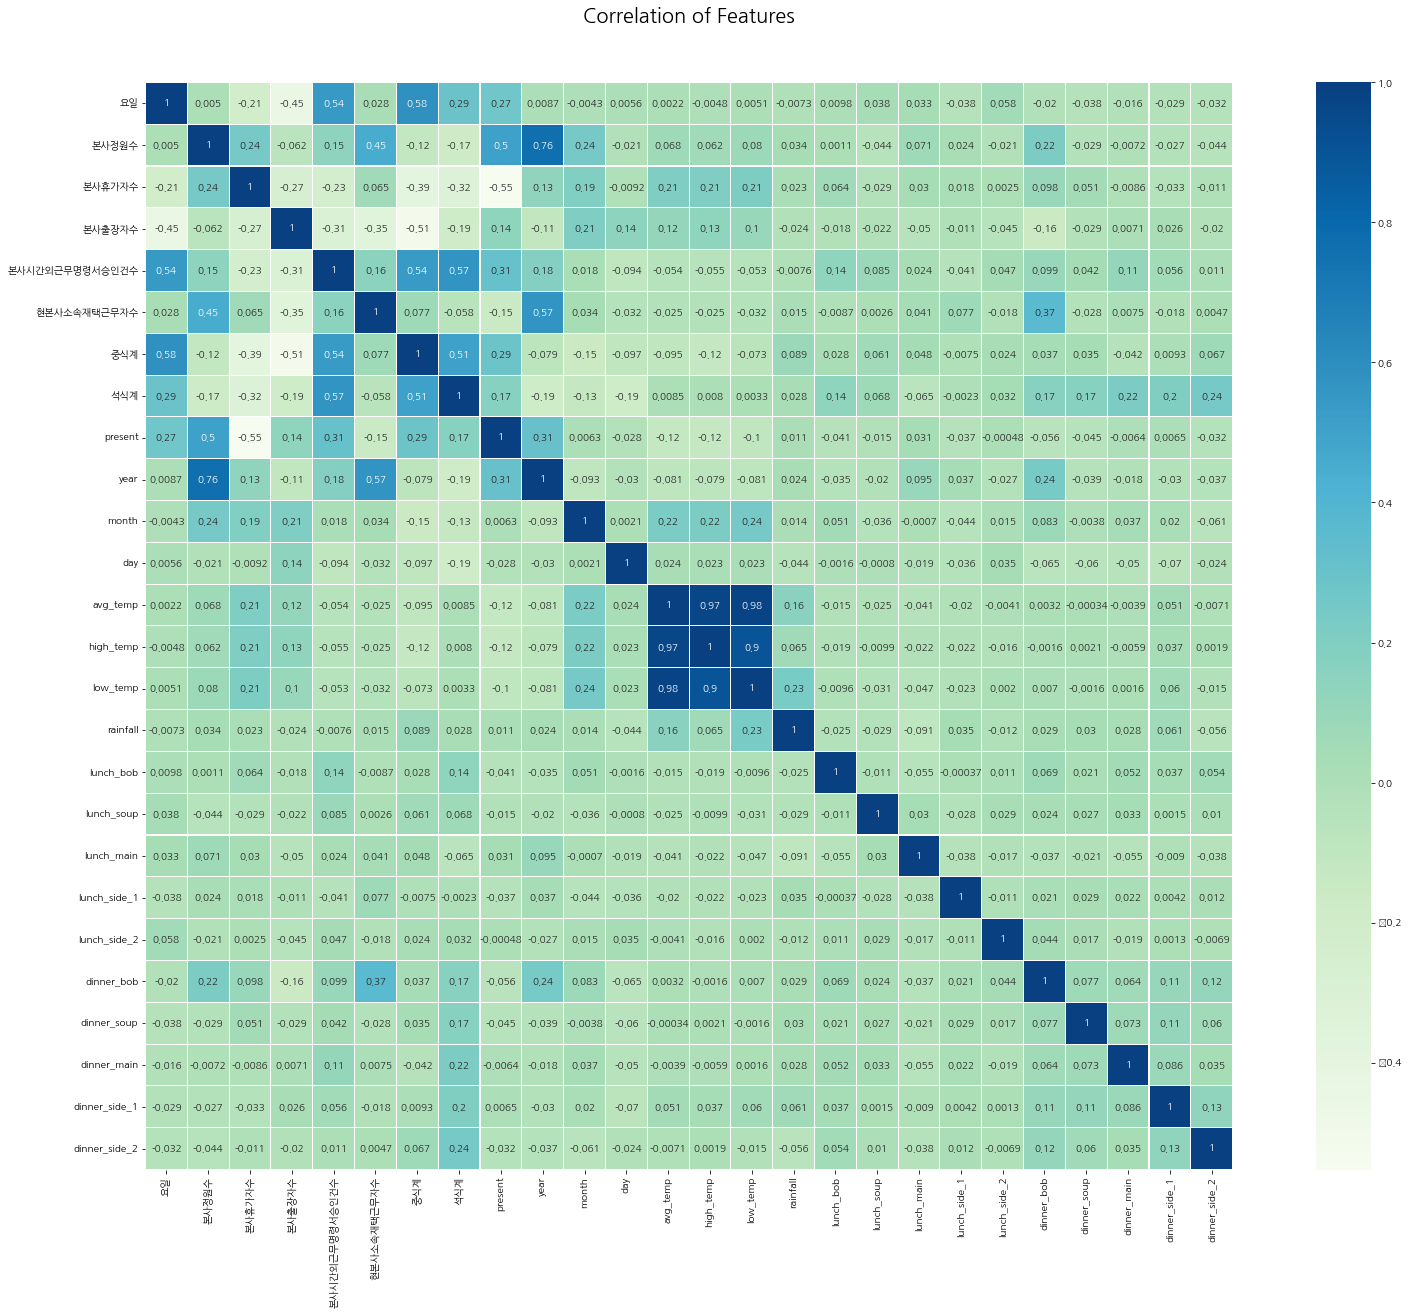

In [54]:
# heatmap
colormap = plt.cm.GnBu 
plt.figure(figsize=(30, 20)) 
plt.title("Correlation of Features", y = 1.05, size = 20) 
sns.heatmap(train_merge.corr(), 
            linewidths = 0.1, 
            vmax = 1.0, 
            square = True, 
            cmap = colormap, 
            linecolor = "white", 
            annot = True, 
            annot_kws = {"size" : 10})

- test 데이터도 똑같이 처리

In [55]:
test_merge['요일'] =  test_merge['요일'].astype('category')
test_merge['요일'] = test_merge.요일.cat.codes

test_merge['year'] =  test_merge['year'].astype('category')
test_merge['year'] = test_merge.year.cat.codes

test_merge['month'] =  test_merge['month'].astype('category')
test_merge['month'] = test_merge.month.cat.codes

test_merge['day'] =  test_merge['day'].astype('category')
test_merge['day'] = test_merge.day.cat.codes

test_merge['lunch_bob'] =  test_merge['lunch_bob'].astype('category')
test_merge['lunch_bob'] = test_merge.lunch_bob.cat.codes

test_merge['lunch_soup'] =  test_merge['lunch_soup'].astype('category')
test_merge['lunch_soup'] = test_merge.lunch_soup.cat.codes

test_merge['lunch_main'] =  test_merge['lunch_main'].astype('category')
test_merge['lunch_main'] = test_merge.lunch_main.cat.codes

test_merge['lunch_side_1'] =  test_merge['lunch_side_1'].astype('category')
test_merge['lunch_side_1'] = test_merge.lunch_side_1.cat.codes

test_merge['lunch_side_2'] =  test_merge['lunch_side_2'].astype('category')
test_merge['lunch_side_2'] = test_merge.lunch_side_2.cat.codes

test_merge['dinner_bob'] =  test_merge['dinner_bob'].astype('category')
test_merge['dinner_bob'] = test_merge.dinner_bob.cat.codes

test_merge['dinner_soup'] =  test_merge['dinner_soup'].astype('category')
test_merge['dinner_soup'] = test_merge.dinner_soup.cat.codes

test_merge['dinner_main'] =  test_merge['dinner_main'].astype('category')
test_merge['dinner_main'] = test_merge.dinner_main.cat.codes

test_merge['dinner_side_1'] =  test_merge['dinner_side_1'].astype('category')
test_merge['dinner_side_1'] = test_merge.dinner_side_1.cat.codes

test_merge['dinner_side_2'] =  test_merge['dinner_side_2'].astype('category')
test_merge['dinner_side_2'] = test_merge.dinner_side_2.cat.codes

In [56]:
test_merge.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,lunch_soup,lunch_main,lunch_side_1,lunch_side_2,dinner,dinner_bob,dinner_soup,dinner_main,dinner_side_1,dinner_side_2
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,9,15,40,23,"[흑미밥, 얼큰순두부찌개, 쇠고기우엉볶음, 버섯햄볶음, 아삭이고추무절임, 포기김치]",14,32,26,25,23


# 3. 모델링

### [중식 예측]

- 데이터 분리

In [335]:
X = train_merge[["요일", "본사정원수", "본사휴가자수", "본사출장자수", "본사시간외근무명령서승인건수", "현본사소속재택근무자수", "year", "month", "day", "present", "lunch_bob", "lunch_soup", "lunch_main", "lunch_side_1", "lunch_side_2", "avg_temp", "high_temp", "low_temp", "rainfall"]]
y = train_merge["중식계"]
test_X = test_merge[["요일", "본사정원수", "본사휴가자수", "본사출장자수", "본사시간외근무명령서승인건수", "현본사소속재택근무자수", "year", "month", "day", "present", "lunch_bob", "lunch_soup", "lunch_main", "lunch_side_1", "lunch_side_2", "avg_temp", "high_temp", "low_temp", "rainfall"]]

- optuna 파라마티 튜닝

In [340]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    # param = {
    #     'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
    #     'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
    #     'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
    #     'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
    #     'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
    #     'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
    #     'n_estimators': 4000,
    #     'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
    #     'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
    #     'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    # }

    param = {
    'max_depth':trial.suggest_categorical('max_depth', [2, 3, 4, 5, 6]),
    'n_estimators': trial.suggest_categorical('n_estimators', [150, 200, 300, 400, 500]),
    'colsample_bytree':trial.suggest_categorical('colsample_bytree', [0.5,0.7,1]),
    'colsample_bylevel':trial.suggest_categorical('colsample_bylevel', [0.5,0.7,1]),
    'gamma': trial.suggest_categorical('gamma', [0.0, 0.1, 0.2, 0.3, 0.4]),
    'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3, 5, 7]),
    }

    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=100,verbose=False)

    preds = model.predict(test_x)
    
    mae = mean_absolute_error(test_y, preds)
    
    return mae

- 파라미터 튜닝

In [342]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-09-18 06:29:03,424] A new study created in memory with name: no-name-e7cfd2bf-b015-45bf-906c-e4c27b6604a1


[06:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:04,221] Trial 0 finished with value: 45.93294292128547 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 0 with value: 45.93294292128547.


[06:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:04,566] Trial 1 finished with value: 47.69402199950666 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 0 with value: 45.93294292128547.


[06:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:05,065] Trial 2 finished with value: 47.97319581890633 and parameters: {'max_depth': 2, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 0 with value: 45.93294292128547.


[06:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:05,691] Trial 3 finished with value: 47.651299758510696 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 0 with value: 45.93294292128547.


[06:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:06,096] Trial 4 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 4 with value: 45.562084400851425.


[06:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:06,505] Trial 5 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:07,209] Trial 6 finished with value: 46.93520202030793 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 5 with value: 45.486630423951546.


[06:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:08,298] Trial 7 finished with value: 46.98155130207209 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 5 with value: 45.486630423951546.


[06:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:08,546] Trial 8 finished with value: 47.91173703630985 and parameters: {'max_depth': 2, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 5 with value: 45.486630423951546.


[06:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:09,519] Trial 9 finished with value: 45.93102666225223 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 5 with value: 45.486630423951546.


[06:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:10,026] Trial 10 finished with value: 46.01349084021637 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 5 with value: 45.486630423951546.


[06:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:10,432] Trial 11 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:10,833] Trial 12 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:11,237] Trial 13 finished with value: 46.72643963012906 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:11,646] Trial 14 finished with value: 46.599077260296646 and parameters: {'max_depth': 6, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:12,016] Trial 15 finished with value: 46.1718432336881 and parameters: {'max_depth': 5, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 5 with value: 45.486630423951546.


[06:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:12,452] Trial 16 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:12,866] Trial 17 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:13,288] Trial 18 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:13,792] Trial 19 finished with value: 46.89659806904872 and parameters: {'max_depth': 4, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 5 with value: 45.486630423951546.


[06:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:14,413] Trial 20 finished with value: 46.21528960262214 and parameters: {'max_depth': 5, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:14,832] Trial 21 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:15,268] Trial 22 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:15,690] Trial 23 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:16,126] Trial 24 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 5 with value: 45.486630423951546.


[06:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:16,612] Trial 25 finished with value: 44.53381634021991 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:17,095] Trial 26 finished with value: 44.53381634021991 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:17,578] Trial 27 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:18,050] Trial 28 finished with value: 45.59443616109658 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:18,542] Trial 29 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:19,021] Trial 30 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:19,503] Trial 31 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:20,002] Trial 32 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:20,484] Trial 33 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:20,956] Trial 34 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:21,374] Trial 35 finished with value: 46.162126794045804 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:21,827] Trial 36 finished with value: 46.103555274931765 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 25 with value: 44.53381634021991.


[06:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:22,487] Trial 37 finished with value: 45.703177469376044 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:22,894] Trial 38 finished with value: 45.865006658912364 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:23,315] Trial 39 finished with value: 48.39716166554235 and parameters: {'max_depth': 2, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 25 with value: 44.53381634021991.


[06:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:23,970] Trial 40 finished with value: 45.79609120155566 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:24,444] Trial 41 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:24,916] Trial 42 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:25,293] Trial 43 finished with value: 45.72683091683941 and parameters: {'max_depth': 6, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:25,696] Trial 44 finished with value: 46.18421315027205 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.3, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:26,279] Trial 45 finished with value: 46.2477071825312 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:26,554] Trial 46 finished with value: 47.08068724495271 and parameters: {'max_depth': 2, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 25 with value: 44.53381634021991.


[06:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:27,102] Trial 47 finished with value: 45.79367040534046 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 25 with value: 44.53381634021991.


[06:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:27,590] Trial 48 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:28,225] Trial 49 finished with value: 46.57008592792637 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:28,761] Trial 50 finished with value: 47.000422024595146 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:29,246] Trial 51 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:29,710] Trial 52 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:30,198] Trial 53 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:30,670] Trial 54 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:31,150] Trial 55 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:31,638] Trial 56 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:32,146] Trial 57 finished with value: 47.32941508951767 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:32,793] Trial 58 finished with value: 46.57008592792637 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:33,283] Trial 59 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:33,969] Trial 60 finished with value: 46.10726261138916 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:34,456] Trial 61 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:34,948] Trial 62 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:35,450] Trial 63 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:35,929] Trial 64 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:36,249] Trial 65 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:36,880] Trial 66 finished with value: 46.21528960262214 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:37,164] Trial 67 finished with value: 47.345308348289514 and parameters: {'max_depth': 4, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:37,825] Trial 68 finished with value: 46.215295539376484 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:38,317] Trial 69 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:38,813] Trial 70 finished with value: 47.877614772451516 and parameters: {'max_depth': 2, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:39,297] Trial 71 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:39,773] Trial 72 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:40,252] Trial 73 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:40,731] Trial 74 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:41,213] Trial 75 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:41,842] Trial 76 finished with value: 46.551139815736214 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:42,550] Trial 77 finished with value: 46.40297560006874 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:43,180] Trial 78 finished with value: 46.21528960262214 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:43,854] Trial 79 finished with value: 46.10726261138916 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:44,268] Trial 80 finished with value: 48.39716166554235 and parameters: {'max_depth': 2, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 25 with value: 44.53381634021991.


[06:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:44,752] Trial 81 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:45,246] Trial 82 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:45,719] Trial 83 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:46,190] Trial 84 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:46,680] Trial 85 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:47,008] Trial 86 finished with value: 46.432524635646885 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:47,644] Trial 87 finished with value: 45.627514725890606 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:47,935] Trial 88 finished with value: 47.345308348289514 and parameters: {'max_depth': 4, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:48,266] Trial 89 finished with value: 46.432524635646885 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 25 with value: 44.53381634021991.


[06:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:48,704] Trial 90 finished with value: 47.32941508951767 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:49,045] Trial 91 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:49,370] Trial 92 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:49,696] Trial 93 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:50,030] Trial 94 finished with value: 45.018163353534035 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:50,811] Trial 95 finished with value: 46.31808682172996 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 5}. Best is trial 25 with value: 44.53381634021991.


[06:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:51,352] Trial 96 finished with value: 44.778171455003935 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:51,875] Trial 97 finished with value: 47.59507247756199 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 25 with value: 44.53381634021991.


[06:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:52,384] Trial 98 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:52,885] Trial 99 finished with value: 44.53381634021991 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:53,381] Trial 100 finished with value: 44.53381634021991 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:53,866] Trial 101 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:54,351] Trial 102 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:54,853] Trial 103 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:55,335] Trial 104 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:55,806] Trial 105 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:56,277] Trial 106 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:56,699] Trial 107 finished with value: 46.936205532010746 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:57,191] Trial 108 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:57,669] Trial 109 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:58,146] Trial 110 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:58,629] Trial 111 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:59,105] Trial 112 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:29:59,587] Trial 113 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:00,072] Trial 114 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:00,547] Trial 115 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:01,208] Trial 116 finished with value: 48.639545489411326 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:01,576] Trial 117 finished with value: 48.212110756510526 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:02,063] Trial 118 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:02,638] Trial 119 finished with value: 46.09237041756593 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:03,122] Trial 120 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:03,604] Trial 121 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:04,106] Trial 122 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:04,593] Trial 123 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:05,090] Trial 124 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:05,575] Trial 125 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:06,070] Trial 126 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:06,562] Trial 127 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:07,058] Trial 128 finished with value: 44.617145868954736 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.3, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:07,534] Trial 129 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:07,966] Trial 130 finished with value: 47.39545146668155 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:08,451] Trial 131 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:08,929] Trial 132 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:09,397] Trial 133 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:09,882] Trial 134 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:10,371] Trial 135 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:10,850] Trial 136 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:11,328] Trial 137 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:12,013] Trial 138 finished with value: 48.77435358584915 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:12,498] Trial 139 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:12,882] Trial 140 finished with value: 47.96300440730311 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:13,377] Trial 141 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:13,864] Trial 142 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:14,344] Trial 143 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:14,819] Trial 144 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:15,330] Trial 145 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:15,820] Trial 146 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:16,648] Trial 147 finished with value: 45.60507986262358 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:16,932] Trial 148 finished with value: 48.35329106104308 and parameters: {'max_depth': 2, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:17,435] Trial 149 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:17,918] Trial 150 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:18,407] Trial 151 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:18,909] Trial 152 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:19,397] Trial 153 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:19,902] Trial 154 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:20,398] Trial 155 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:20,779] Trial 156 finished with value: 46.72930850310879 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:21,266] Trial 157 finished with value: 46.01605448999457 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 98 with value: 44.53379620109474.


[06:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:21,696] Trial 158 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:22,336] Trial 159 finished with value: 47.40840185808214 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:22,826] Trial 160 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:23,323] Trial 161 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:23,794] Trial 162 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:24,274] Trial 163 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:24,751] Trial 164 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:25,238] Trial 165 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:25,728] Trial 166 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:26,211] Trial 167 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:26,699] Trial 168 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:27,575] Trial 169 finished with value: 48.77435358584915 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:28,118] Trial 170 finished with value: 47.91297317209823 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:28,606] Trial 171 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:29,092] Trial 172 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:29,574] Trial 173 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:30,056] Trial 174 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:30,459] Trial 175 finished with value: 47.93939021937755 and parameters: {'max_depth': 2, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:30,942] Trial 176 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:31,419] Trial 177 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:31,960] Trial 178 finished with value: 45.71046303385529 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 98 with value: 44.53379620109474.


[06:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:32,470] Trial 179 finished with value: 44.53960778041439 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:32,950] Trial 180 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:33,460] Trial 181 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:33,956] Trial 182 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:34,456] Trial 183 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:34,964] Trial 184 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:35,462] Trial 185 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:35,789] Trial 186 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:36,172] Trial 187 finished with value: 46.729307466449 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:36,668] Trial 188 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:37,170] Trial 189 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:37,682] Trial 190 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:38,183] Trial 191 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:38,693] Trial 192 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:39,191] Trial 193 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:39,686] Trial 194 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:40,185] Trial 195 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:40,693] Trial 196 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:41,185] Trial 197 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:41,695] Trial 198 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:42,390] Trial 199 finished with value: 47.40026020345108 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:42,897] Trial 200 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:43,395] Trial 201 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:43,910] Trial 202 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:44,415] Trial 203 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:44,921] Trial 204 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:45,429] Trial 205 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:45,916] Trial 206 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:46,415] Trial 207 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:46,926] Trial 208 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:48,050] Trial 209 finished with value: 48.87675757697933 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:48,563] Trial 210 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:49,074] Trial 211 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:49,594] Trial 212 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:50,118] Trial 213 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:50,642] Trial 214 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:51,155] Trial 215 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:51,839] Trial 216 finished with value: 47.72607669909356 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:52,346] Trial 217 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:52,814] Trial 218 finished with value: 49.30720262369398 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 98 with value: 44.53379620109474.


[06:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:53,332] Trial 219 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:54,073] Trial 220 finished with value: 45.489979770302114 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 98 with value: 44.53379620109474.


[06:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:54,587] Trial 221 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:55,090] Trial 222 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:55,595] Trial 223 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:56,100] Trial 224 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:56,607] Trial 225 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:57,120] Trial 226 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:57,635] Trial 227 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:58,071] Trial 228 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:58,575] Trial 229 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:59,223] Trial 230 finished with value: 46.55114718761234 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:30:59,716] Trial 231 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:00,221] Trial 232 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:00,720] Trial 233 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:01,218] Trial 234 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:01,716] Trial 235 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:02,235] Trial 236 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:02,739] Trial 237 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:03,236] Trial 238 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:03,749] Trial 239 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:04,474] Trial 240 finished with value: 47.40026020345108 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:04,990] Trial 241 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:05,500] Trial 242 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:06,013] Trial 243 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:06,529] Trial 244 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:07,032] Trial 245 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:07,536] Trial 246 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:08,033] Trial 247 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:08,538] Trial 248 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:09,048] Trial 249 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:09,558] Trial 250 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:10,063] Trial 251 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:10,560] Trial 252 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:11,440] Trial 253 finished with value: 47.113228526563276 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:11,956] Trial 254 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:12,432] Trial 255 finished with value: 47.57078365199474 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 98 with value: 44.53379620109474.


[06:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:13,171] Trial 256 finished with value: 45.909656479872396 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 98 with value: 44.53379620109474.


[06:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:14,165] Trial 257 finished with value: 46.120204042334585 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:14,676] Trial 258 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:15,187] Trial 259 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:15,682] Trial 260 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:16,176] Trial 261 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:16,660] Trial 262 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:17,166] Trial 263 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:17,795] Trial 264 finished with value: 46.55114718761234 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:18,303] Trial 265 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:18,754] Trial 266 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:19,446] Trial 267 finished with value: 47.40026020345108 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:19,965] Trial 268 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:20,454] Trial 269 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:20,961] Trial 270 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:21,451] Trial 271 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:21,964] Trial 272 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:22,718] Trial 273 finished with value: 44.74252351212897 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:23,865] Trial 274 finished with value: 48.87675757697933 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:24,385] Trial 275 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:24,897] Trial 276 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:25,410] Trial 277 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:26,060] Trial 278 finished with value: 47.91297317209823 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:26,720] Trial 279 finished with value: 45.47145207679074 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 98 with value: 44.53379620109474.


[06:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:27,472] Trial 280 finished with value: 46.970446133481865 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 98 with value: 44.53379620109474.


[06:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:27,974] Trial 281 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:28,481] Trial 282 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:28,998] Trial 283 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:29,491] Trial 284 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:29,993] Trial 285 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:30,491] Trial 286 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:30,983] Trial 287 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:31,481] Trial 288 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:31,915] Trial 289 finished with value: 45.486630423951546 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:32,664] Trial 290 finished with value: 45.8691326689325 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:33,160] Trial 291 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:33,665] Trial 292 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:34,186] Trial 293 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:34,698] Trial 294 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:35,454] Trial 295 finished with value: 44.74252351212897 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:35,818] Trial 296 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 150, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:36,335] Trial 297 finished with value: 48.662397361592035 and parameters: {'max_depth': 6, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:36,843] Trial 298 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


[06:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:31:37,364] Trial 299 finished with value: 44.53379620109474 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 98 with value: 44.53379620109474.


Number of finished trials: 300
Best trial: {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}


- 학습

In [343]:
# 최적의 파라미터
Best_trial = {'max_depth': 6, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}

# 예측
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=10,random_state=42,shuffle=True)
mae=[]   # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(X, y):
    X_tr,X_val=X.iloc[trn_idx],X.iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=200,verbose=False)
    preds += model.predict(test_X)/kf.n_splits
    mae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,mae[n])
    n+=1

[06:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 68.46869199138042
[06:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 71.3841981493737
[06:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 65.81871852401859
[06:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4 69.80370942423167
[06:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5 47.63252195247934
[06:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6 58.8202158610026
[06:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squared

- 평가

In [344]:
np.mean(mae) # 66.21250435863317

65.72240196984663

- 제출물 입력

In [345]:
submission['중식계'] = preds

- 변수 중요도 파악

In [346]:
from sklearn.inspection import permutation_importance

result_xg = permutation_importance(model, X,y , n_repeats=10, random_state=48, n_jobs=2)
sorted_idx_xg = result_xg.importances_mean.argsort()
importances_xg = pd.DataFrame(result_xg.importances_mean[sorted_idx_xg], index=X.columns[sorted_idx_xg]).sort_values(0, ascending=False).iloc[:45]

In [347]:
importances_xg

,0
본사출장자수,0.322199
요일,0.282737
본사시간외근무명령서승인건수,0.219837
본사휴가자수,0.185439
month,0.055833
본사정원수,0.039677
day,0.030342
year,0.027414
현본사소속재택근무자수,0.010001


### [석식]

- 데이터 분리

In [370]:
X = train_merge[["요일", "본사정원수", "본사휴가자수", "본사출장자수", "본사시간외근무명령서승인건수", "현본사소속재택근무자수", "year", "month", "day", "present", "dinner_bob", "dinner_soup", "dinner_main", "dinner_side_1", "dinner_side_2", "avg_temp", "high_temp", "low_temp", "rainfall"]]
y = train_merge["석식계"]
test_X = test_merge[["요일", "본사정원수", "본사휴가자수", "본사출장자수", "본사시간외근무명령서승인건수", "현본사소속재택근무자수", "year", "month", "day", "present", "dinner_bob", "dinner_soup", "dinner_main", "dinner_side_1", "dinner_side_2", "avg_temp", "high_temp", "low_temp", "rainfall"]]

In [371]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-09-18 06:40:34,015] A new study created in memory with name: no-name-0cccd337-456f-4923-891d-07cdb22b07b5


[06:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:34,297] Trial 0 finished with value: 48.342023371332914 and parameters: {'max_depth': 2, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 5}. Best is trial 0 with value: 48.342023371332914.


[06:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:34,890] Trial 1 finished with value: 47.8541603799683 and parameters: {'max_depth': 2, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 1 with value: 47.8541603799683.


[06:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:35,375] Trial 2 finished with value: 47.24421180941123 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 2 with value: 47.24421180941123.


[06:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:36,108] Trial 3 finished with value: 46.113744568100294 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 3 with value: 46.113744568100294.


[06:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:36,662] Trial 4 finished with value: 47.13707126306566 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 3 with value: 46.113744568100294.


[06:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:37,001] Trial 5 finished with value: 46.55026167548822 and parameters: {'max_depth': 5, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 3 with value: 46.113744568100294.


[06:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:37,379] Trial 6 finished with value: 46.45656232148903 and parameters: {'max_depth': 4, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 3 with value: 46.113744568100294.


[06:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:37,794] Trial 7 finished with value: 46.572128532999784 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 3 with value: 46.113744568100294.


[06:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:38,407] Trial 8 finished with value: 47.56437626464591 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 3 with value: 46.113744568100294.


[06:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:38,882] Trial 9 finished with value: 46.50273455308946 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 3 with value: 46.113744568100294.


[06:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:39,262] Trial 10 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:39,634] Trial 11 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:40,016] Trial 12 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:40,391] Trial 13 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:41,187] Trial 14 finished with value: 46.86024171871375 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:41,558] Trial 15 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:41,959] Trial 16 finished with value: 47.39884027064834 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:42,339] Trial 17 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:43,147] Trial 18 finished with value: 46.86024171871375 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:43,574] Trial 19 finished with value: 46.830114398872 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 10 with value: 45.45521558977622.


[06:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:43,958] Trial 20 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:44,346] Trial 21 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:44,743] Trial 22 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:45,134] Trial 23 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:45,363] Trial 24 finished with value: 45.47225912499823 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:46,163] Trial 25 finished with value: 46.86024171871375 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:46,538] Trial 26 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 45.45521558977622.


[06:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:46,976] Trial 27 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:47,584] Trial 28 finished with value: 46.53506209837139 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:47,879] Trial 29 finished with value: 47.13849170563629 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:48,441] Trial 30 finished with value: 45.627514725890606 and parameters: {'max_depth': 5, 'n_estimators': 300, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:48,884] Trial 31 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:49,326] Trial 32 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:49,714] Trial 33 finished with value: 46.993804440643245 and parameters: {'max_depth': 2, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:50,053] Trial 34 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:50,566] Trial 35 finished with value: 46.01349084021637 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:51,009] Trial 36 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:51,420] Trial 37 finished with value: 46.843163616749464 and parameters: {'max_depth': 2, 'n_estimators': 300, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:52,119] Trial 38 finished with value: 46.81624694489643 and parameters: {'max_depth': 5, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 27 with value: 45.321371771354045.


[06:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:52,449] Trial 39 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:52,904] Trial 40 finished with value: 46.45901614098259 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:53,341] Trial 41 finished with value: 45.70520502559388 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 3}. Best is trial 27 with value: 45.321371771354045.


[06:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:53,574] Trial 42 finished with value: 45.66073187214235 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:53,867] Trial 43 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:54,272] Trial 44 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 27 with value: 45.321371771354045.


[06:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:54,972] Trial 45 finished with value: 45.721560737704706 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 27 with value: 45.321371771354045.


[06:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:55,364] Trial 46 finished with value: 46.993804440643245 and parameters: {'max_depth': 2, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:56,030] Trial 47 finished with value: 46.10726261138916 and parameters: {'max_depth': 5, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:56,297] Trial 48 finished with value: 47.006857661252525 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 27 with value: 45.321371771354045.


[06:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:56,605] Trial 49 finished with value: 46.3244655764564 and parameters: {'max_depth': 4, 'n_estimators': 200, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 27 with value: 45.321371771354045.


[06:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:57,036] Trial 50 finished with value: 45.70520502559388 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 3}. Best is trial 27 with value: 45.321371771354045.


[06:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:57,598] Trial 51 finished with value: 45.11607869817407 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 51 with value: 45.11607869817407.


[06:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:58,029] Trial 52 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 51 with value: 45.11607869817407.


[06:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:58,468] Trial 53 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 51 with value: 45.11607869817407.


[06:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:58,896] Trial 54 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 51 with value: 45.11607869817407.


[06:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:40:59,332] Trial 55 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 51 with value: 45.11607869817407.


[06:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:00,041] Trial 56 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:00,750] Trial 57 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:01,826] Trial 58 finished with value: 45.69095260596407 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:02,542] Trial 59 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:03,190] Trial 60 finished with value: 46.8715110786712 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:03,893] Trial 61 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:04,627] Trial 62 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:05,335] Trial 63 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:06,028] Trial 64 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:06,739] Trial 65 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:07,441] Trial 66 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:08,116] Trial 67 finished with value: 46.10726261138916 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:08,732] Trial 68 finished with value: 47.19797888381705 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:09,432] Trial 69 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:09,796] Trial 70 finished with value: 45.97845182300273 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:10,506] Trial 71 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:11,199] Trial 72 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:11,897] Trial 73 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:12,606] Trial 74 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:12,936] Trial 75 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:13,639] Trial 76 finished with value: 45.974002763052674 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:14,041] Trial 77 finished with value: 49.402434180454655 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:14,757] Trial 78 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:15,453] Trial 79 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:16,283] Trial 80 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:16,985] Trial 81 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:17,693] Trial 82 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:18,398] Trial 83 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:19,112] Trial 84 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:19,828] Trial 85 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:20,144] Trial 86 finished with value: 46.75887131032364 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:20,714] Trial 87 finished with value: 47.13707126306566 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:21,334] Trial 88 finished with value: 46.1014984334042 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:22,006] Trial 89 finished with value: 45.721560737704706 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:22,262] Trial 90 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:22,972] Trial 91 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:23,675] Trial 92 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:24,381] Trial 93 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:25,091] Trial 94 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:25,384] Trial 95 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:26,044] Trial 96 finished with value: 46.8715110786712 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:26,769] Trial 97 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:27,304] Trial 98 finished with value: 47.59507247756199 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:28,158] Trial 99 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:28,860] Trial 100 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:29,557] Trial 101 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:30,268] Trial 102 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:30,962] Trial 103 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:31,667] Trial 104 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:32,219] Trial 105 finished with value: 46.42633210493056 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:32,467] Trial 106 finished with value: 45.66073187214235 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:33,171] Trial 107 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:33,582] Trial 108 finished with value: 47.000422024595146 and parameters: {'max_depth': 5, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:34,137] Trial 109 finished with value: 46.72967212107959 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:34,850] Trial 110 finished with value: 45.974002763052674 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:35,547] Trial 111 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:36,248] Trial 112 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:36,949] Trial 113 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:37,650] Trial 114 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:38,358] Trial 115 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:39,037] Trial 116 finished with value: 46.8715110786712 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:39,748] Trial 117 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:40,086] Trial 118 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:40,804] Trial 119 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:41,765] Trial 120 finished with value: 46.529938487552144 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:42,468] Trial 121 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:43,169] Trial 122 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:43,874] Trial 123 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:44,578] Trial 124 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:45,301] Trial 125 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:45,618] Trial 126 finished with value: 46.75887131032364 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:46,026] Trial 127 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:46,735] Trial 128 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:47,059] Trial 129 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:47,294] Trial 130 finished with value: 45.66073187214235 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:48,004] Trial 131 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:48,726] Trial 132 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:49,465] Trial 133 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:50,202] Trial 134 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:50,930] Trial 135 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:51,604] Trial 136 finished with value: 47.635671807916125 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:52,316] Trial 137 finished with value: 45.974002763052674 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:53,128] Trial 138 finished with value: 46.52284239141981 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:53,833] Trial 139 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:54,561] Trial 140 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:55,278] Trial 141 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:55,970] Trial 142 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:56,667] Trial 143 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:57,398] Trial 144 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:58,112] Trial 145 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:58,823] Trial 146 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:41:59,166] Trial 147 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:00,023] Trial 148 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:00,469] Trial 149 finished with value: 46.45901614098259 and parameters: {'max_depth': 6, 'n_estimators': 400, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:01,177] Trial 150 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:01,886] Trial 151 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:02,597] Trial 152 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:03,311] Trial 153 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:04,014] Trial 154 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:04,739] Trial 155 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:05,448] Trial 156 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:05,678] Trial 157 finished with value: 45.66073187214235 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:06,408] Trial 158 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:06,706] Trial 159 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:07,070] Trial 160 finished with value: 45.97845182300273 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:07,769] Trial 161 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:08,482] Trial 162 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:09,180] Trial 163 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:09,884] Trial 164 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:10,282] Trial 165 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:10,981] Trial 166 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:11,688] Trial 167 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:12,404] Trial 168 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:12,917] Trial 169 finished with value: 46.0942781854071 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:13,408] Trial 170 finished with value: 46.993804440643245 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:14,116] Trial 171 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:14,829] Trial 172 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:15,535] Trial 173 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:16,223] Trial 174 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:16,938] Trial 175 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:17,667] Trial 176 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:18,527] Trial 177 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:18,869] Trial 178 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:19,207] Trial 179 finished with value: 46.75887131032364 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:19,936] Trial 180 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:20,654] Trial 181 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:21,370] Trial 182 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:22,102] Trial 183 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:22,817] Trial 184 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:23,547] Trial 185 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:24,263] Trial 186 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:24,978] Trial 187 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:25,713] Trial 188 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:26,414] Trial 189 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:26,739] Trial 190 finished with value: 47.727287508506144 and parameters: {'max_depth': 6, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:27,472] Trial 191 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:28,190] Trial 192 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:28,922] Trial 193 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:29,634] Trial 194 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:30,343] Trial 195 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:31,070] Trial 196 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:31,430] Trial 197 finished with value: 45.97845182300273 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:31,749] Trial 198 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:32,442] Trial 199 finished with value: 47.130444709767296 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:33,169] Trial 200 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:33,901] Trial 201 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:34,616] Trial 202 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:35,339] Trial 203 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:36,039] Trial 204 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:36,766] Trial 205 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:37,493] Trial 206 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:38,214] Trial 207 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:38,930] Trial 208 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:39,634] Trial 209 finished with value: 45.974002763052674 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:40,141] Trial 210 finished with value: 46.993804440643245 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:40,862] Trial 211 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:41,569] Trial 212 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:42,281] Trial 213 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:42,954] Trial 214 finished with value: 46.1014984334042 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:43,678] Trial 215 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:44,412] Trial 216 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:45,282] Trial 217 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:45,984] Trial 218 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:46,703] Trial 219 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:47,415] Trial 220 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:48,136] Trial 221 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:48,731] Trial 222 finished with value: 45.11607869817407 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:49,471] Trial 223 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:50,204] Trial 224 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:50,934] Trial 225 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:51,713] Trial 226 finished with value: 47.89046747381516 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:52,433] Trial 227 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:53,171] Trial 228 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:53,894] Trial 229 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:54,617] Trial 230 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:55,335] Trial 231 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:56,039] Trial 232 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:56,735] Trial 233 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:57,456] Trial 234 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:58,163] Trial 235 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:58,884] Trial 236 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:59,144] Trial 237 finished with value: 47.46339324791787 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:42:59,681] Trial 238 finished with value: 47.59507247756199 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:00,395] Trial 239 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:01,123] Trial 240 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:01,843] Trial 241 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:02,578] Trial 242 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:03,290] Trial 243 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:04,044] Trial 244 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:04,793] Trial 245 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:05,113] Trial 246 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:05,505] Trial 247 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:05,990] Trial 248 finished with value: 47.852170177586174 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:06,723] Trial 249 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:07,465] Trial 250 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:08,192] Trial 251 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:08,916] Trial 252 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:09,407] Trial 253 finished with value: 46.993804440643245 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:10,268] Trial 254 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:10,985] Trial 255 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:11,700] Trial 256 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:12,431] Trial 257 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:13,071] Trial 258 finished with value: 46.1014984334042 and parameters: {'max_depth': 5, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:13,413] Trial 259 finished with value: 46.75887131032364 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:13,755] Trial 260 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:14,518] Trial 261 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:14,961] Trial 262 finished with value: 45.321371771354045 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:15,671] Trial 263 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:16,376] Trial 264 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:17,088] Trial 265 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:17,801] Trial 266 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:18,171] Trial 267 finished with value: 45.97845182300273 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:18,421] Trial 268 finished with value: 45.79288093029465 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:18,847] Trial 269 finished with value: 49.402434180454655 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.0, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:19,572] Trial 270 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:20,300] Trial 271 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:20,689] Trial 272 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:21,002] Trial 273 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:21,723] Trial 274 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:22,595] Trial 275 finished with value: 46.005316734313965 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:23,311] Trial 276 finished with value: 45.974002763052674 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 3}. Best is trial 56 with value: 45.0153653107954.


[06:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:24,049] Trial 277 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:24,792] Trial 278 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:25,511] Trial 279 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:26,220] Trial 280 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:26,928] Trial 281 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:27,560] Trial 282 finished with value: 46.9057753481259 and parameters: {'max_depth': 2, 'n_estimators': 500, 'colsample_bytree': 1, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:28,262] Trial 283 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.3, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:28,944] Trial 284 finished with value: 46.1014984334042 and parameters: {'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:29,529] Trial 285 finished with value: 45.11607869817407 and parameters: {'max_depth': 3, 'n_estimators': 400, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:29,860] Trial 286 finished with value: 45.746640670365394 and parameters: {'max_depth': 4, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:30,576] Trial 287 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:31,282] Trial 288 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:31,667] Trial 289 finished with value: 45.97845182300273 and parameters: {'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:32,400] Trial 290 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:33,110] Trial 291 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:33,841] Trial 292 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:34,566] Trial 293 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:35,333] Trial 294 finished with value: 45.0153653107954 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:35,755] Trial 295 finished with value: 49.402434180454655 and parameters: {'max_depth': 6, 'n_estimators': 500, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:36,003] Trial 296 finished with value: 45.66073187214235 and parameters: {'max_depth': 3, 'n_estimators': 150, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.2, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


[06:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:36,426] Trial 297 finished with value: 45.562084400851425 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 1}. Best is trial 56 with value: 45.0153653107954.


[06:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:36,838] Trial 298 finished with value: 45.45521558977622 and parameters: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 5}. Best is trial 56 with value: 45.0153653107954.


[06:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-18 06:43:37,158] Trial 299 finished with value: 45.559789523235345 and parameters: {'max_depth': 3, 'n_estimators': 200, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.4, 'min_child_weight': 7}. Best is trial 56 with value: 45.0153653107954.


Number of finished trials: 300
Best trial: {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}


In [372]:
# 최적의 파라미터
Best_trial = {'max_depth': 3, 'n_estimators': 500, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'gamma': 0.1, 'min_child_weight': 7}

# 예측
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=10,random_state=42,shuffle=True)
mae=[]   # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(X, y):
    X_tr,X_val=X.iloc[trn_idx],X.iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=200,verbose=False)
    preds += model.predict(test_X)/kf.n_splits
    mae.append(mean_absolute_error(y_val, model.predict(X_val)))
    print(n+1,mae[n])
    n+=1

[06:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 48.03588155675526
[06:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 44.426133539065845
[06:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 44.28122053067546
[06:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4 45.93286084734704
[06:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5 43.551883555640856
[06:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6 48.64655730724335
[06:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

In [373]:
np.mean(mae)  # 46.29533655165477

46.69921437567977

In [374]:
submission['석식계'] = preds

In [375]:
from sklearn.inspection import permutation_importance

result_xg = permutation_importance(model, X,y , n_repeats=10, random_state=48, n_jobs=2)
sorted_idx_xg = result_xg.importances_mean.argsort()
importances_xg = pd.DataFrame(result_xg.importances_mean[sorted_idx_xg], index=X.columns[sorted_idx_xg]).sort_values(0, ascending=False).iloc[:45]
importances_xg

,0
본사시간외근무명령서승인건수,0.380817
year,0.096838
month,0.070755
dinner_bob,0.067263
dinner_side_1,0.067184
본사휴가자수,0.064781
본사출장자수,0.043963
present,0.028738
dinner_main,0.019930
dinner_side_2,0.018410


In [376]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,1011.197243,423.056480
1,2021-01-28,956.500008,494.830681
2,2021-01-29,647.772583,288.634760
3,2021-02-01,1211.236977,576.318417
4,2021-02-02,1015.534805,532.204178


In [377]:
submission.to_csv('./data/submission/submission_29.csv', index=False)